# Air Brakes Example


In [1]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, Function
from datetime import datetime

In [2]:
%matplotlib inline


Gravity Details

Acceleration of gravity at surface level:    9.7913 m/s²
Acceleration of gravity at  10.000 km (ASL): 9.7649 m/s²


Launch Site Details

Launch Site Latitude: 32.99025°
Launch Site Longitude: -106.97500°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315468.64 W    3651938.65 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1400.0 m


Atmospheric Model Details

Atmospheric Model Type: custom_atmosphere
custom_atmosphere Maximum Height: 10.000 km


Surface Atmospheric Conditions

Surface Wind Speed: 4.69 m/s
Surface Wind Direction: 219.81°
Surface Wind Heading: 39.81°
Surface Pressure: 856.02 hPa
Surface Temperature: 279.07 K
Surface Air Density: 1.069 kg/m³
Surface Speed of Sound: 334.55 m/s


Earth Model Details

Earth Radius at Launch site: 6371.83 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034


Atmospheric Model Plots



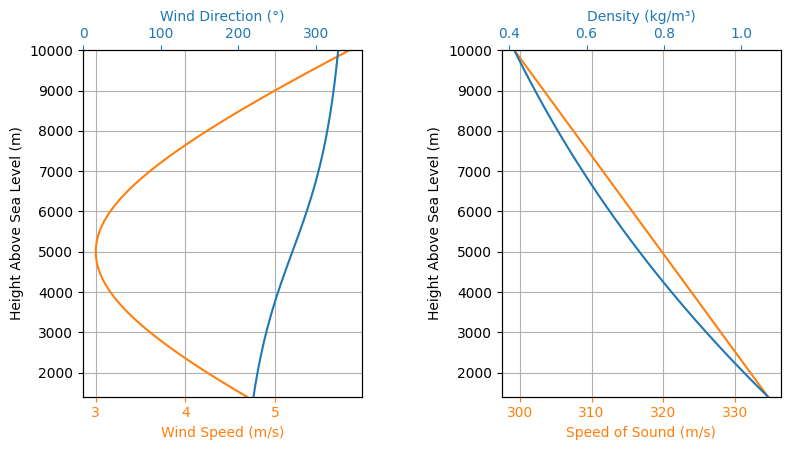

In [3]:
env = Environment(latitude=32.990254, longitude=-106.974998, elevation=1400)
env.set_atmospheric_model(
    type="custom_atmosphere", wind_u=[(0, 3), (10000, 3)], wind_v=[(0, 5), (10000, -5)]
)
env.info()

In [4]:
Pro75M1670 = SolidMotor(
    thrust_source="../../data/motors/Cesaroni_M1670.eng",
    dry_mass=1.815,
    dry_inertia=(0.125, 0.125, 0.002),
    nozzle_radius=33 / 1000,
    grain_number=5,
    grain_density=1815,
    grain_outer_radius=33 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.397,
    center_of_dry_mass_position=0.317,
    nozzle_position=0,
    burn_time=3.9,
    throat_radius=11 / 1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

In [5]:
calisto = Rocket(
    radius=127 / 2000,
    mass=14.426,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="../../data/calisto/powerOffDragCurve.csv",
    power_on_drag="../../data/calisto/powerOnDragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

rail_buttons = calisto.set_rail_buttons(
    upper_button_position=0.0818,
    lower_button_position=-0.618,
    angular_position=45,
)

calisto.add_motor(Pro75M1670, position=-1.255)

nose_cone = calisto.add_nose(length=0.55829, kind="vonKarman", position=1.278)

fin_set = calisto.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
    airfoil=("../../data/calisto/NACA0012-radians.csv", "radians"),
)

tail = calisto.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)

In [6]:
def controller_function(
    time, sampling_rate, state, state_history, observed_variables, air_brakes
):
    # state = [x, y, z, vx, vy, vz, e0, e1, e2, e3, wx, wy, wz]
    altitude_ASL = state[2]
    altitude_AGL = altitude_ASL - env.elevation
    vx, vy, vz = state[3], state[4], state[5]

    # Get winds in x and y directions
    wind_x, wind_y = env.wind_velocity_x(altitude_ASL), env.wind_velocity_y(
        altitude_ASL
    )

    # Calculate Mach number
    free_stream_speed = ((wind_x - vx) ** 2 + (wind_y - vy) ** 2 + (vz) ** 2) ** 0.5
    mach_number = free_stream_speed / env.speed_of_sound(altitude_ASL)

    # Get previous state from state_history
    previous_state = state_history[-1]
    previous_vz = previous_state[5]

    # If we wanted to we could get the returned values from observed_variables:
    # returned_time, deployment_level, drag_coefficient = observed_variables[-1]

    # Check if the rocket has reached burnout
    if time < Pro75M1670.burn_out_time:
        return None

    # If below 1500 meters above ground level, air_brakes are not deployed
    if altitude_AGL < 1500:
        air_brakes.deployment_level = 0

    # Else calculate the deployment level
    else:
        # Controller logic
        new_deployment_level = (
            air_brakes.deployment_level + 0.1 * vz + 0.01 * previous_vz**2
        )

        # Limiting the speed of the air_brakes to 0.2 per second
        # Since this function is called every 1/sampling_rate seconds
        # the max change in deployment level per call is 0.2/sampling_rate
        max_change = 0.2 / sampling_rate
        lower_bound = air_brakes.deployment_level - max_change
        upper_bound = air_brakes.deployment_level + max_change
        new_deployment_level = min(max(new_deployment_level, lower_bound), upper_bound)

        air_brakes.deployment_level = new_deployment_level

    # Return variables of interest to be saved in the observed_variables list
    return (
        time,
        air_brakes.deployment_level,
        air_brakes.drag_coefficient(air_brakes.deployment_level, mach_number),
    )

In [7]:
air_brakes = calisto.add_air_brakes(
    drag_coefficient_curve="../../data/calisto/air_brakes_cd.csv",
    controller_function=controller_function,
    sampling_rate=10,
    reference_area=None,
    clamp=True,
    initial_observed_variables=[0, 0, 0],
    override_rocket_drag=False,
    name="AirBrakes",
    controller_name="AirBrakes Controller",
)

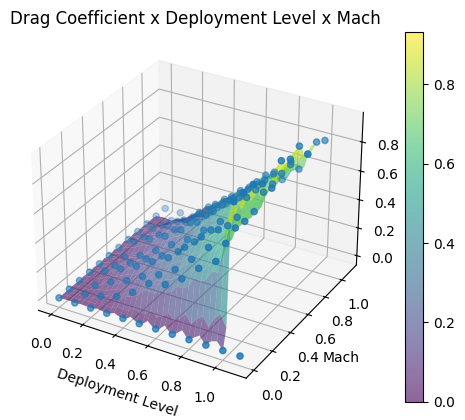

In [8]:
air_brakes.all_info()

In [9]:
test_flight = Flight(
    rocket=calisto,
    environment=env,
    rail_length=5.2,
    inclination=85,
    heading=0,
    time_overshoot=False,
    terminate_on_apogee=True,
)

## Analyzing the Results

Now we can see some plots from our air brakes:

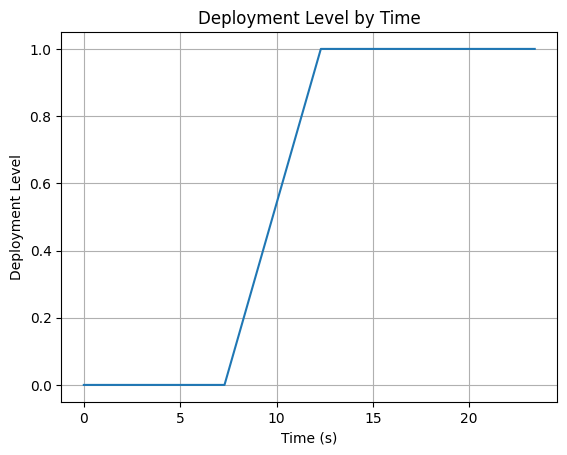

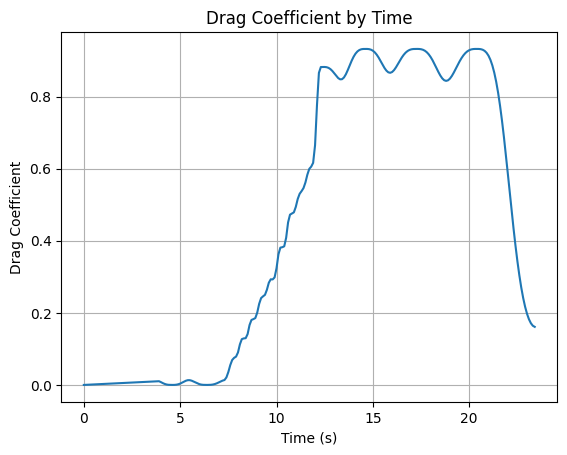

In [11]:
import matplotlib.pyplot as plt

time, deployment_level, drag_coefficient = zip(
    *test_flight.get_controller_observed_variables
)

# plot deployment level by time
plt.plot(time, deployment_level)
plt.xlabel("Time (s)")
plt.ylabel("Deployment Level")
plt.title("Deployment Level by Time")
plt.grid()
plt.show()

# plot drag coefficient by time
plt.plot(time, drag_coefficient)
plt.xlabel("Time (s)")
plt.ylabel("Drag Coefficient")
plt.title("Drag Coefficient by Time")
plt.grid()
plt.show()

And of course, the simulation results:


Burn out State

Burn out time: 3.900 s
Altitude at burn out: 658.678 m (AGL)
Rocket velocity at burn out: 279.367 m/s
Freestream velocity at burn out: 279.392 m/s
Mach Number at burn out: 0.842
Kinetic energy at burn out: 6.338e+05 J

Apogee State

Apogee Altitude: 4413.436 m (ASL) | 3013.436 m (AGL)
Apogee Time: 23.416 s
Apogee Freestream Speed: 11.706 m/s


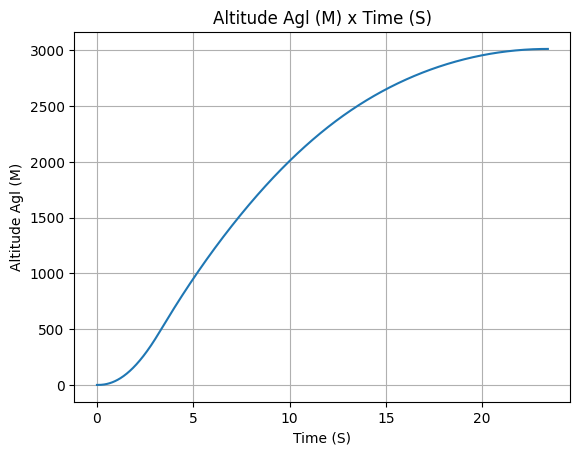

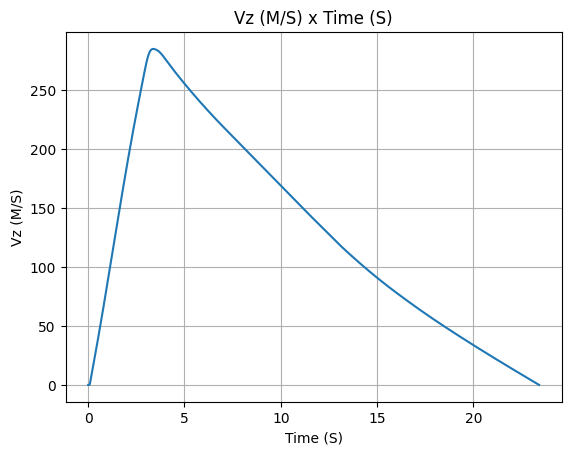

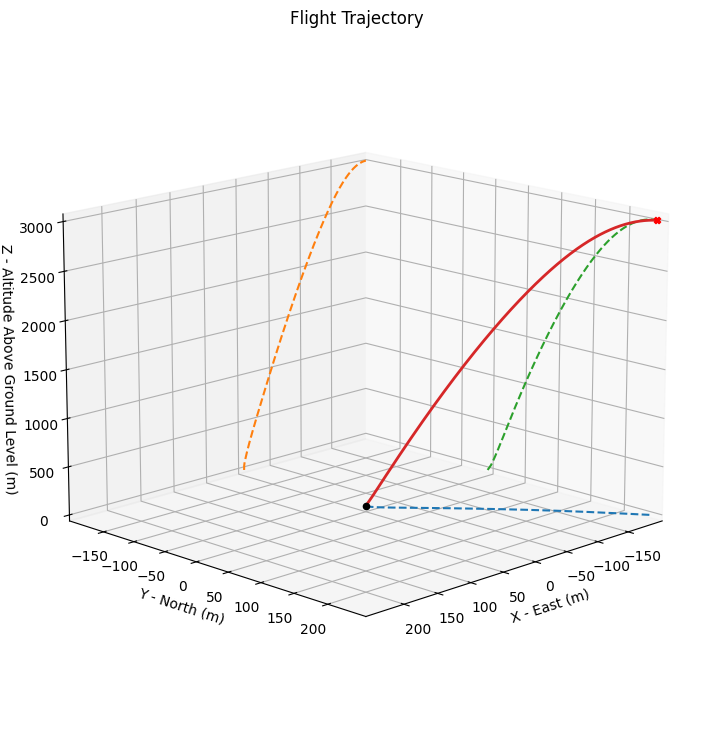

In [12]:
test_flight.prints.burn_out_conditions()
test_flight.prints.apogee_conditions()
test_flight.altitude()
test_flight.vz()
test_flight.plots.trajectory_3d()